In [16]:
#import libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates


#### Load in data

In [41]:
#load data
hate_sample = pd.read_csv('../hate_posts.csv')
baseline_sample = pd.read_csv('../baseline_posts.csv')

In [42]:
filtered_hate = hate_sample[(hate_sample['toxicity'] > 0.7) & (hate_sample['sexually_explicit'] < 0.3)]

In [43]:
#convert strings to datetime objects
filtered_hate['date'] = filtered_hate['date'].apply(datetime.datetime.strptime, args=['%Y-%m-%d'])
baseline_sample['date'] = baseline_sample['date'].apply(datetime.datetime.strptime, args=['%Y-%m-%d'])

/tmp/ipykernel_3980269/3245857008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_hate['date'] = filtered_hate['date'].apply(datetime.datetime.strptime, args=['%Y-%m-%d'])


In [26]:
#subsample the baseline posts
subsample = baseline_sample[baseline_sample['date'] < datetime.datetime(2022, 12, 1)].sample(frac=0.2, random_state=42)

subsampled_df = pd.concat([subsample, baseline_sample[baseline_sample['date'] >= datetime.datetime(2022, 12, 1)]])

### Figure 1: Volume of hate speech over time

In [15]:
hate_tweets = np.array([])
date = datetime.datetime(2022, 1, 1, 0, 0)
dates = []
control_tweets = np.array([])

#multipliers for calculating the total amount of posts per week, since we only sample 5 or 25 minutes per day.
hate_multiplier = 1440 / 25
baseline_multiplier = 1440 / 5

while date < datetime.datetime(2023, 6, 9): #loop through the weeks in the sample
    new_date = date + datetime.timedelta(days=7) #update the date
                
    dates.append(new_date)
    
    hate_tweets = np.append(hate_tweets, len(filtered_hate[(filtered_hate['date'] <= new_date) & (filtered_hate['date'] > date)]) * hate_multiplier)
    if new_date < datetime.datetime(2022, 12, 1) or date > datetime.datetime(2022, 12, 31): #remove the month of december as this contains incomplete data
        control_tweets = np.append(control_tweets, len(subsampled_df[(subsampled_df['date'] <= new_date) & (subsampled_df['date'] > date)]) * baseline_multiplier)
        
    else:
        control_tweets = np.append(control_tweets, np.nan)
        
    date = new_date

/tmp/ipykernel_3980269/4239823040.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation=45, rotation_mode='anchor')


Text(2022-11-05 00:00:00, 25000000, 'Musk buys\nTwitter/X')

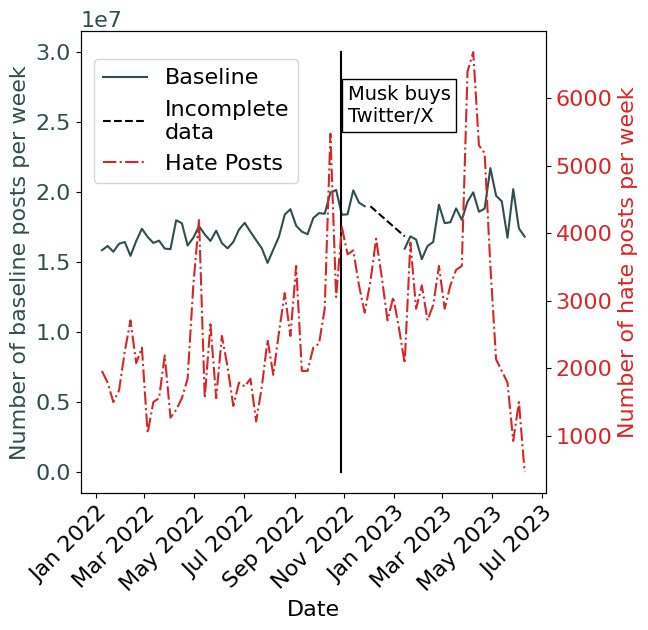

In [17]:
plt.rc('font', size=16)

fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(111)

ax2 = ax1.twinx() #different axes for baseline/hate

ax1.plot(dates, control_tweets, label='Baseline', color='darkslategray')
ax2.plot(dates, hate_tweets, label='Hate Posts', color='tab:red', linestyle='-.')

ax1.plot([dates[47], dates[53]], [control_tweets[46], control_tweets[54]], color='k', linestyle='--', label='Incomplete\ndata')

ax1.plot([datetime.datetime(2022, 10, 28, 1, 0), datetime.datetime(2022, 10, 28, 1, 0)], [0, 30000000], color='k')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax2.set_ylabel("Number of hate posts per week", c='tab:red')

axbox = ax1.get_position()
fig.legend(loc=(axbox.x0 + 0.02, axbox.y0 + 0.60), fontsize=16)


ax1.set_xlabel("Date")
ax1.set_ylabel("Number of baseline posts per week", c='darkslategray')
ax1.tick_params(axis='y', labelcolor='darkslategray')
ax2.tick_params(axis='y', labelcolor='tab:red')


ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', rotation=45, rotation_mode='anchor')

ax1.text(dates[43], 25000000, 'Musk buys\nTwitter/X', bbox=dict(facecolor='None'), fontsize=14)


#plt.savefig('./fig1.png', dpi=300, bbox_inches='tight')

### Figure 2: Mean likes and reposts per week

In [27]:
# remove posts with reposts to get more accurate like/repost counts
hate_no_repost = filtered_hate[filtered_hate['is_rt'] == False]
baseline_no_repost = subsampled_df[subsampled_df['is_rt'] == False]

In [29]:
import datetime
hate_likes = np.array([])
hate_reposts = np.array([])
control_likes = np.array([])
control_reposts = np.array([])

date = datetime.datetime(2022, 1, 1, 0, 0)
dates = []



multiplier = 1440 / 5
hate_multiplier = 1440 / 25

counter = 0

while date < datetime.datetime(2023, 6, 9):
    new_date = date + datetime.timedelta(days=7)
            
    dates.append(new_date)
    
    if datetime.datetime(2022, 10, 28, 1, 0) <= new_date and datetime.datetime(2022, 10, 28, 1, 0) > date:
        post_musk_index = counter
        
    hate_likes = np.append(hate_likes, (hate_no_repost[(hate_no_repost['date'] <= new_date) & (hate_no_repost['date'] > date)]['like_count'].sum() * hate_multiplier))
    hate_reposts = np.append(hate_reposts, (hate_no_repost[(hate_no_repost['date'] <= new_date) & (hate_no_repost['date'] > date)]['retweet_count'].sum() * hate_multiplier))

    if new_date < datetime.datetime(2022, 12, 1) or date > datetime.datetime(2022, 12, 31):
        control_likes = np.append(control_likes, (baseline_no_repost[(baseline_no_repost['date'] <= new_date) & (baseline_no_repost['date'] > date)]['like_count'].sum()) * multiplier)
        control_reposts = np.append(control_reposts, (baseline_no_repost[(baseline_no_repost['date'] <= new_date) & (baseline_no_repost['date'] > date)]['retweet_count'].sum()) * multiplier)


    else:
        control_likes = np.append(control_likes, np.nan)
        control_reposts = np.append(control_reposts, np.nan)
        
    date = new_date
    counter += 1

Text(0.5, 1.0, 'Baseline')

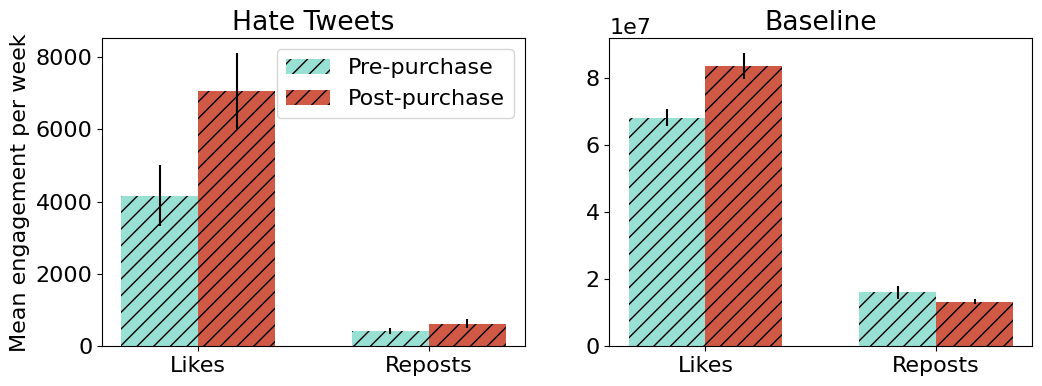

In [31]:
plt.rc('font', size=16)

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)

ax2 = fig.add_subplot(122)

width = 0.25

before = [-.5, 0.25]
after = [-.25, 0.5]

ax.bar(before, [np.mean(hate_likes[:post_musk_index]), np.mean(hate_reposts[:post_musk_index])], width, label='Pre-purchase', color='#8DDDD0', hatch='//', alpha=0.9)
ax.bar(after, [np.mean(hate_likes[post_musk_index:]), np.mean(hate_reposts[post_musk_index:])], width, label='Post-purchase', color='#CA472F', hatch='//', alpha=0.9)

ax.errorbar(before, [np.mean(hate_likes[:post_musk_index]), np.mean(hate_reposts[:post_musk_index])], 
            yerr=[(np.std(hate_likes[:post_musk_index]) / np.sqrt(post_musk_index)), (np.std(hate_reposts[:post_musk_index]) / np.sqrt(post_musk_index))],
            color='k', linestyle='')

ax.errorbar(after, [np.mean(hate_likes[post_musk_index:]), np.mean(hate_reposts[post_musk_index:])], 
            yerr=[(np.std(hate_likes[post_musk_index:]) / np.sqrt(len(hate_likes) - post_musk_index)),
                  (np.std(hate_reposts[post_musk_index:]) / np.sqrt(len(hate_likes) - post_musk_index))], color='k', linestyle='')

ax.set_xticks([-0.375, 0.375])
ax.set_xticklabels(['Likes', 'Reposts'])

ax.set_title("Hate Tweets")

ax.legend()

ax.set_ylabel("Mean engagement per week")

ax2.bar(before, [np.mean(control_likes[:post_musk_index]), np.mean(control_reposts[:post_musk_index])], width, label='Pre-purchase', color='#8DDDD0', hatch='//', alpha=0.9)
ax2.bar(after, [np.mean(control_likes[post_musk_index:][~np.isnan(control_likes[post_musk_index:])]), np.mean(control_reposts[post_musk_index:][~np.isnan(control_reposts[post_musk_index:])])], width, label='Post-purchase', color='#CA472F', hatch='//', alpha=0.9)

ax2.errorbar(before, [np.mean(control_likes[:post_musk_index]), np.mean(control_reposts[:post_musk_index])], 
            yerr=[(np.std(control_likes[:post_musk_index]) / np.sqrt(post_musk_index)), (np.std(control_reposts[:post_musk_index]) / np.sqrt(post_musk_index))],
            color='k', linestyle='')

ax2.errorbar(after, [np.mean(control_likes[post_musk_index:][~np.isnan(control_likes[post_musk_index:])]), np.mean(control_reposts[post_musk_index:][~np.isnan(control_reposts[post_musk_index:])])], 
            yerr=[(np.std(control_likes[post_musk_index:][~np.isnan(control_likes[post_musk_index:])]) / np.sqrt(len(control_likes) - post_musk_index - 4)),
                  (np.std(control_reposts[post_musk_index:][~np.isnan(control_reposts[post_musk_index:])]) / np.sqrt(len(control_likes) - post_musk_index - 4))], color='k', linestyle='')

ax2.set_xticks([-0.375, 0.375])
ax2.set_xticklabels(['Likes', 'Reposts'])

ax2.set_title("Baseline")


#plt.savefig('./fig2.png', dpi=300, bbox_inches='tight')

### Figure 3: Hate speech by category

In [44]:
anti_trans = np.array([])
racist = np.array([])
homophobic = np.array([])

date = datetime.datetime(2022, 1, 1, 0, 0)
dates = []
counter = 0

multiplier = 1440 / 25

while date < datetime.datetime(2023, 6, 9):
    new_date = date + datetime.timedelta(days=7)
    
    dates.append(new_date)
    
    if datetime.datetime(2022, 10, 28, 1, 0) <= new_date and datetime.datetime(2022, 10, 28, 1, 0) > date:
        post_musk_index = counter
        
    anti_trans = np.append(anti_trans, len(filtered_hate[(filtered_hate['date'] <= new_date) & (filtered_hate['date'] > date)
                                                       & (filtered_hate['transphobic'] == 1)]) * multiplier)
    
    racist = np.append(racist, len(filtered_hate[(filtered_hate['date'] <= new_date) & (filtered_hate['date'] > date)
                                                       & (filtered_hate['racist'] == 1)]) * multiplier)
    
    homophobic = np.append(homophobic, len(filtered_hate[(filtered_hate['date'] <= new_date) & (filtered_hate['date'] > date)
                                                       & (filtered_hate['homophobic'] == 1)]) * multiplier)
        
    
    date = new_date
    counter += 1

In [45]:
#remove the weeks with the highest amount of hate speech for each category
racist_no_spike = np.concatenate((racist[:np.argmax(racist)], racist[np.argmax(racist) + 1:]))
homophobic_no_spike = np.concatenate((homophobic[:np.argmax(homophobic)], homophobic[np.argmax(homophobic) + 1:]))
anti_trans_no_spike = np.concatenate((anti_trans[:np.argmax(anti_trans)], anti_trans[np.argmax(anti_trans) + 1:]))

In [46]:
#the racist peak is pre-musk, but the other ones are post-musk
racist_before = racist_no_spike[:post_musk_index - 1]
racist_after = racist_no_spike[post_musk_index - 1:]
homophobic_before = homophobic_no_spike[:post_musk_index]
homophobic_after = homophobic_no_spike[post_musk_index:]
anti_trans_before = anti_trans_no_spike[:post_musk_index]
anti_trans_after = anti_trans_no_spike[post_musk_index:]

Text(0, 0.5, 'Mean hate posts per week')

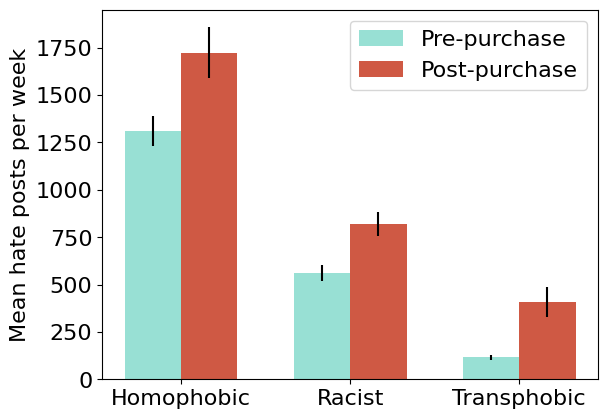

In [47]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.rc('font', size=16)

width = 0.25

before = [-.5, 0.25, 1]
after = [-.25, 0.5, 1.25]

ax.bar(before, [np.mean(homophobic_before), np.mean(racist_before), np.mean(anti_trans_before)], width, label='Pre-purchase', color='#8DDDD0', alpha=0.9)
ax.bar(after, [np.mean(homophobic_after), np.mean(racist_after), np.mean(anti_trans_after)], width, label='Post-purchase', color='#CA472F', alpha=0.9)

ax.errorbar(before, [np.mean(homophobic_before), np.mean(racist_before), np.mean(anti_trans_before)], 
            yerr=[(np.std(homophobic_before) / np.sqrt(len(homophobic_before))), (np.std(racist_before) / np.sqrt(len(racist_before))),
                 (np.std(anti_trans_before) / np.sqrt(len(anti_trans_before)))], color='k', linestyle='')

ax.errorbar(after, [np.mean(homophobic_after), np.mean(racist_after), np.mean(anti_trans_after)], 
            yerr=[(np.std(homophobic_after) / np.sqrt(len(homophobic_after))), (np.std(racist_after) / np.sqrt(len(racist_after))),
                 (np.std(anti_trans_after) / np.sqrt(len(anti_trans_after)))], color='k', linestyle='')

ax.set_xticks([-0.375, 0.375, 1.125])
ax.set_xticklabels(['Homophobic', 'Racist', 'Transphobic'])

ax.legend()

ax.set_ylabel("Mean hate posts per week")

#plt.savefig('./fig3.png', dpi=300, bbox_inches='tight')